In [36]:
import sys
sys.path.insert(0, '..')

import random
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
from functools import partial
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns

from core.multimodal.dataset import collate_fn, ASASSNVarStarDataset
from core.multimodal.dataset2 import VGDataset
from models.Informer import Informer

In [2]:
g_data = VGDataset('/home/mariia/AstroML/data/asassn', 'g.csv', split='all')

Split is not train, val, or test. Keeping the whole dataset
all split is selected: 378823 objects left.


In [7]:
g_data.df['target'].value_counts().sort_index().index

Index(['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'L',
       'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR', 'VAR', 'YSO'],
      dtype='object', name='target')

In [97]:
model

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(2, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-7): 8 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=128, out_features=128, bias=True)
          (key_projection): Linear(in_features=128, out_features=128, bias=True)
          (value_projection): Linear(in_features=128, out_features=128, bias=True)
          (out_projection): Linear(in_features=128, out_features=128, bias=True)
        )
        (conv1): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
  

In [9]:
CLASSES = ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW',
           'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR']

In [95]:
val_dataset = VGDataset('/home/mariia/AstroML/data/asassn', 'g.csv', split='val', seq_len=200, max_samples=20000, phased=True, periodic=True, 
                        classes=CLASSES, clip=False, random_seed=66, scales='mean-mad')
test_dataset = VGDataset('/home/mariia/AstroML/data/asassn', 'g.csv', split='test', seq_len=200, max_samples=20000, phased=True, periodic=True, 
                        classes=CLASSES, clip=False, random_seed=66, scales='mean-mad')

Leaving only classes: ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR']... 363971 objects left.
Removing objects without periods... 355142 objects left.
Removing objects that have more than 20000 or less than None samples... 131937 objects left.
val split is selected: 13194 objects left.
Leaving only classes: ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR']... 363971 objects left.
Removing objects without periods... 355142 objects left.
Removing objects that have more than 20000 or less than None samples... 131937 objects left.
test split is selected: 13194 objects left.


In [96]:
ls = []

for i in tqdm(np.random.randint(0, len(val_dataset), 10000)):
    lc = val_dataset.get_glc(val_dataset.df.iloc[i]['name'])
    ls.append(len(lc))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 257.57it/s]


In [94]:
min(ls), max(ls), sum(ls) / len(ls)

(29, 868989, 1541.0011)

In [47]:
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4)
test_datalaoder = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4)

In [12]:
mapping = {'CWA': 'CEPH', 'CWB': 'CEPH', 'DCEP': 'CEPH', 'DCEPS': 'CEPH', 'DSCT': 'DSCT', 'EA': 'ECL', 'EB': 'ECL', 'EW': 'ECL', 'HADS': 'DSCT', 'L': 'LPV', 
           'M': 'LPV', 'ROT': 'ROT', 'RRAB': 'RRAB', 'RRC': 'RRc/RRd', 'RRD': 'RRc/RRd', 'RVA': 'CEPH', 'SR': 'LPV', 'VAR': 'LPV', 'YSO': 'LPV'}

In [21]:
model = Informer(enc_in=2, d_model=128, n_heads=4, d_ff=512, e_layers=8, seq_len=200, num_class=v_data.num_classes)
model.load_state_dict(torch.load('/home/mariia/AstroML/weights/2024-05-23-08-32-i5buxncs/weights-99.pth'))

<All keys matched successfully>

In [27]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print('Using', device)

Using cuda:3


In [48]:
model.eval()

all_true_labels = []
all_predicted_labels = []

for el in tqdm(val_dataloader):
    with torch.no_grad():
        X, mask, y = el
        X, mask = X.to(device), mask.to(device)
        X = X[:, :, 1:]

        logits = model(X, mask)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)

        all_true_labels.extend(y.numpy())
        all_predicted_labels.extend(predicted_labels.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:18<00:00,  1.67it/s]


In [49]:
sum([all_true_labels[i] == all_predicted_labels[i] for i in range(len(all_predicted_labels))])/len(all_predicted_labels)

0.7930922547555671

Text(0.5, 1.0, 'Confusion Matrix - Percentages')

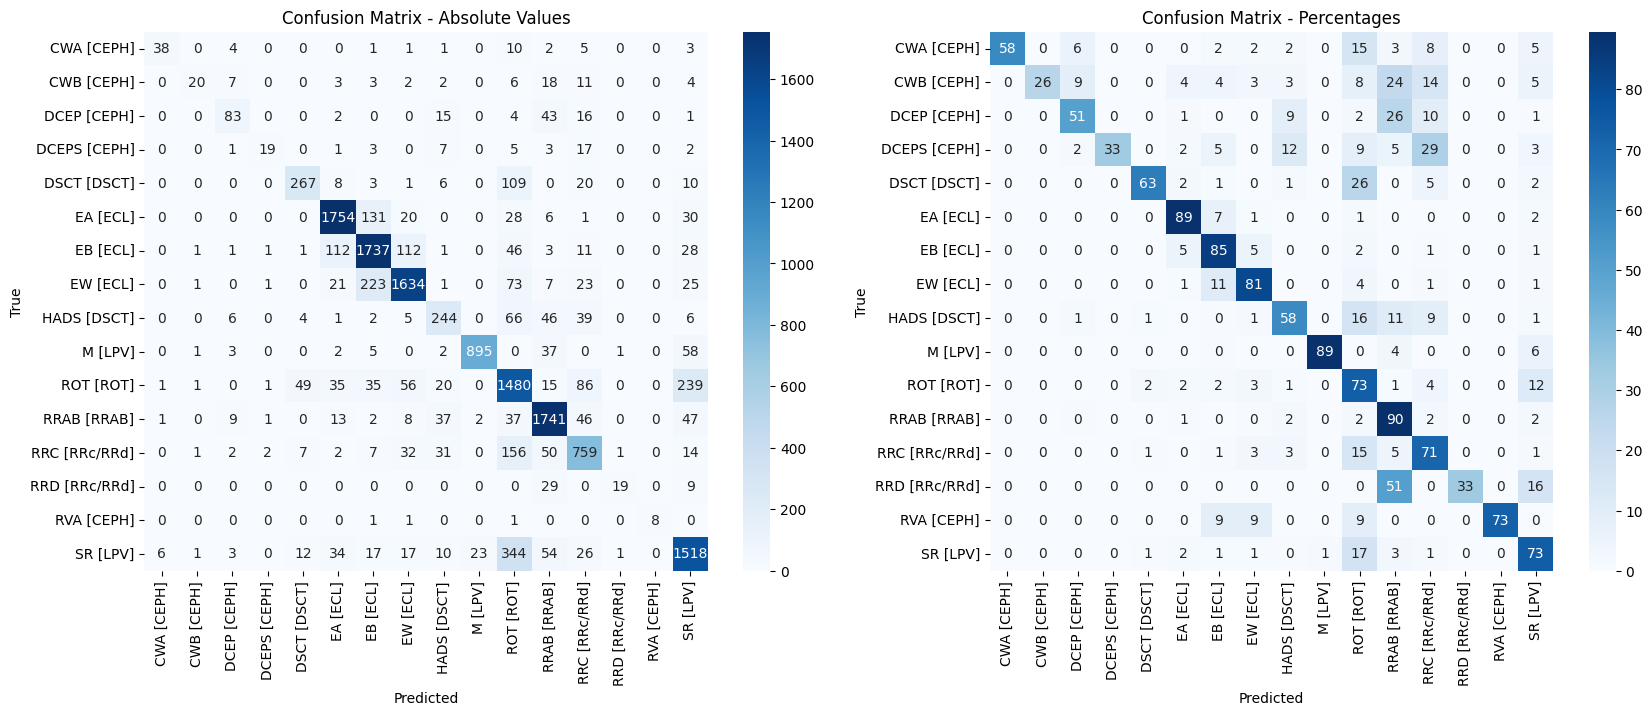

In [60]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Calculate percentage values for confusion matrix
conf_matrix_percent = 100 * conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Get the labels from the id2target mapping
labels = [val_dataset.id2target[i] for i in range(len(conf_matrix))]
labels = [f'{el} [{mapping[el]}]' for el in labels]

# Plot both confusion matrices side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# Plot absolute values confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix - Absolute Values')

# Plot percentage values confusion matrix
sns.heatmap(conf_matrix_percent, annot=True, fmt='.0f', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Confusion Matrix - Percentages')